1- Data Preparation
a. Import the CSV files: TwitterPreCovidEraData.CSV and TwitterPostCovidEraData.CSV
b. Perform data cleaning: remove duplicates, irrelevant data, URLs, mentions, emojis, and special characters
c. Pre-process the text: convert to lowercase, remove punctuation, tokenize, and lemmatize

In [4]:
import os
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

In [5]:
# Set data directory path
data_dir = "/Users/hannesyilmaz/Desktop/ECDataProject"

# Load CSV files
pre_covid_path = os.path.join(data_dir, "TwitterPreCovidEraData.CSV")
post_covid_path = os.path.join(data_dir, "TwitterPostCovidEraData.CSV")

pre_covid_data = pd.read_csv(pre_covid_path, on_bad_lines="skip")
post_covid_data = pd.read_csv(post_covid_path, on_bad_lines="skip")


/var/folders/r_/j66c0c851qb14zzfdkr7vc6m0000gn/T/ipykernel_72529/3024194690.py:8: DtypeWarning: Columns (9,21) have mixed types. Specify dtype option on import or set low_memory=False.
  pre_covid_data = pd.read_csv(pre_covid_path, on_bad_lines="skip")


In [6]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#[^#]*$", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"[^A-Za-z\s]", "", text)
    text = text.lower()
    return text


# Apply data cleaning
pre_covid_data["cleaned_text"] = pre_covid_data["tweet"].apply(clean_text)
post_covid_data["cleaned_text"] = post_covid_data["Content"].apply(clean_text)


In [7]:
# Text pre-processing function
def preprocess_text(text):
    tokenized = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word) for word in tokenized]
    return " ".join(lemmatized)

In [8]:
# Download required NLTK resources
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("omw-1.4")


# Apply text pre-processing
pre_covid_data["preprocessed_text"] = pre_covid_data["cleaned_text"].apply(preprocess_text)
post_covid_data["preprocessed_text"] = post_covid_data["cleaned_text"].apply(preprocess_text)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/hannesyilmaz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/hannesyilmaz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/hannesyilmaz/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [9]:
# Combine the datasets and split into training and testing sets
all_data = pd.concat([pre_covid_data, post_covid_data])
train_data, test_data = train_test_split(all_data, test_size=0.2, random_state=42)

# Save pre-processed data to pickle files
train_data.to_pickle(os.path.join(data_dir, "train_data.pkl"))
test_data.to_pickle(os.path.join(data_dir, "test_data.pkl"))


In [10]:
# Read the train_data.pkl and test_data.pkl files
train_data_check = pd.read_pickle(os.path.join(data_dir, "train_data.pkl"))
test_data_check = pd.read_pickle(os.path.join(data_dir, "test_data.pkl"))

# Print the first 5 rows of the train_data and test_data DataFrames
print("Train data:")
print(train_data_check.head())

print("\nTest data:")
print(test_data_check.head())


Train data:
                   id  conversation_id    created_at        date      time  \
531931   3.420000e+17     3.420000e+17  1.370360e+12  04/06/2013  19:46:15   
2189299  1.200000e+18     1.200000e+18  1.570000e+12  25/11/2019  12:50:40   
1182246  6.890000e+17     6.890000e+17  1.453010e+12  17/01/2016  09:18:45   
1340644  8.100000e+17     8.100000e+17  1.480000e+12  18/12/2016  11:06:36   
2143178  1.180000e+18     1.180000e+18  1.570000e+12  11/10/2019  23:08:50   

                        timezone       user_id        username  \
531931   E. Africa Standard Time  1.754178e+08      joey_nolan   
2189299  E. Africa Standard Time  1.950142e+08    radioshemsfm   
1182246  E. Africa Standard Time  2.773298e+09  khalidrafiq138   
1340644  E. Africa Standard Time  8.167793e+08        japamarc   
2143178  E. Africa Standard Time  1.572479e+09       africanlm   

                       name place  ... user_rt_id user_rt retweet_id  \
531931           Joey Nolan   NaN  ...        NaN 

In [11]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download("vader_lexicon")

def label_sentiment(text):
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(text)["compound"]
    
    if sentiment >= 0.05:
        return "positive"
    elif sentiment <= -0.05:
        return "negative"
    else:
        return "neutral"

sample_size = 100000
train_data_sample = train_data.sample(n=sample_size, random_state=42)
test_data_sample = test_data.sample(n=sample_size, random_state=42)

train_data_sample["label"] = train_data_sample["preprocessed_text"].apply(label_sentiment)
test_data_sample["label"] = test_data_sample["preprocessed_text"].apply(label_sentiment)

train_data_sample = train_data_sample.dropna(subset=['preprocessed_text'])
test_data_sample = test_data_sample.dropna(subset=['preprocessed_text'])


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/hannesyilmaz/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


2- Sentiment Analysis Model Selection and Training
a. Choose a sentiment analysis model (e.g., Naïve Bayes, Support Vector Machine, LSTM, BERT)
b. Train the model on the pre-processed training data
c. Evaluate the model using the testing data and adjust hyperparameters as needed
d. Repeat steps b and c until the desired performance is achieved

In [12]:
import os
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [13]:
# Create the CountVectorizer
vectorizer = CountVectorizer(stop_words="english")

# Fit the vectorizer to the training data
X_train = vectorizer.fit_transform(train_data_sample["preprocessed_text"])

# Fit the Naïve Bayes classifier
clf = MultinomialNB()
y_train = train_data_sample["label"]
clf.fit(X_train, y_train)

MultinomialNB()

In [14]:
# Transform the test data using the trained vectorizer
X_test = vectorizer.transform(test_data_sample["preprocessed_text"])
y_test = test_data_sample["label"]

In [15]:
# Make predictions on the test data
y_pred = clf.predict(X_test)

In [16]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7478

Classification Report:
              precision    recall  f1-score   support

    negative       0.71      0.82      0.76     31779
     neutral       0.90      0.63      0.74     38591
    positive       0.67      0.83      0.74     29630

    accuracy                           0.75    100000
   macro avg       0.76      0.76      0.75    100000
weighted avg       0.77      0.75      0.75    100000



3 - Model Application and Analysis
a. Applying the trained model to the pre-processed Pre-COVID and Post-COVID datasets
b. Calculating sentiment scores for each tweet (e.g., positive, negative, neutral)
c. Aggregating the sentiment scores for both datasets to determine overall sentiment (e.g., average score, percentage of positive/negative/neutral tweets)

In [17]:
# Model Application and Analysis

# Apply the trained model to the pre-processed Pre-COVID and Post-COVID datasets
X_pre_covid = vectorizer.transform(pre_covid_data["preprocessed_text"])
X_post_covid = vectorizer.transform(post_covid_data["preprocessed_text"])


In [18]:
# Calculate sentiment scores for each tweet
pre_covid_data["sentiment"] = clf.predict(X_pre_covid)
post_covid_data["sentiment"] = clf.predict(X_post_covid)

In [19]:
# Aggregate the sentiment scores for both datasets
def sentiment_summary(df):
    sentiment_counts = df["sentiment"].value_counts(normalize=True) * 100
    avg_sentiment = (sentiment_counts["positive"] - sentiment_counts["negative"]) / 100
    return sentiment_counts, avg_sentiment

In [20]:
pre_covid_sentiment_counts, pre_covid_avg_sentiment = sentiment_summary(pre_covid_data)
post_covid_sentiment_counts, post_covid_avg_sentiment = sentiment_summary(post_covid_data)


In [21]:
print("Pre-COVID Sentiment Counts (Percentage):\n", pre_covid_sentiment_counts)
print("Pre-COVID Average Sentiment:", pre_covid_avg_sentiment)

Pre-COVID Sentiment Counts (Percentage):
 negative    36.589635
positive    36.310742
neutral     27.099623
Name: sentiment, dtype: float64
Pre-COVID Average Sentiment: -0.0027889288363032705


In [22]:
print("\nPost-COVID Sentiment Counts (Percentage):\n", post_covid_sentiment_counts)
print("Post-COVID Average Sentiment:", post_covid_avg_sentiment)


Post-COVID Sentiment Counts (Percentage):
 positive    73.748309
negative    14.208390
neutral     12.043302
Name: sentiment, dtype: float64
Post-COVID Average Sentiment: 0.5953991880920163


4 - Comparative Analysis
a. Compare the overall sentiment scores between the Pre-COVID and Post-COVID datasets
b. Identify significant differences in sentiment (e.g., increased/decreased negativity or positivity)
c. Visualize the results using bar charts, pie charts, or line charts to illustrate the sentiment differences

In [23]:
import matplotlib.pyplot as plt
import numpy as np

In [24]:
def plot_sentiment_distribution(sentiment_counts, title):
    labels = sentiment_counts.index
    sizes = sentiment_counts.values

    fig, ax = plt.subplots()
    ax.bar(labels, sizes, align='center', alpha=0.5)
    ax.set_title(title)
    ax.set_ylabel('Percentage')
    ax.set_ylim(0, 100)
    plt.show()

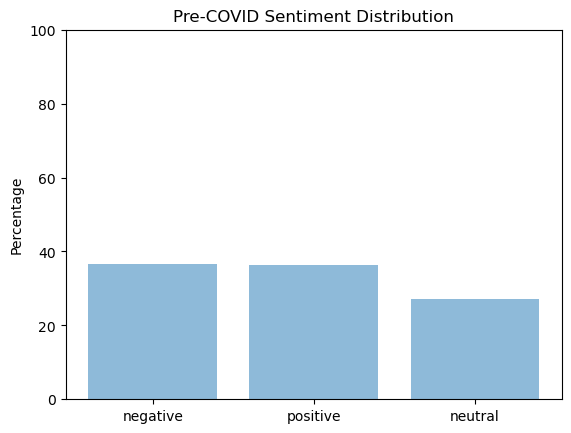

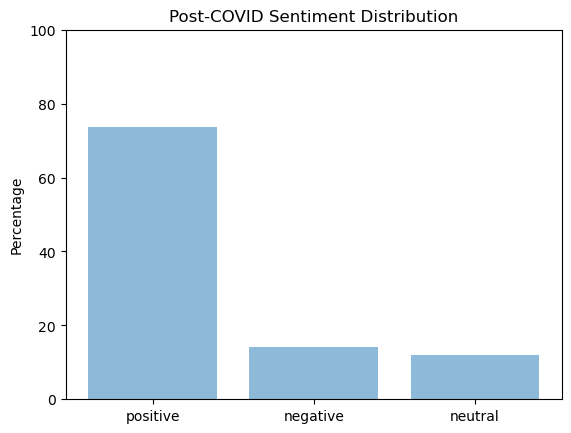

In [25]:
plot_sentiment_distribution(pre_covid_sentiment_counts, 'Pre-COVID Sentiment Distribution')
plot_sentiment_distribution(post_covid_sentiment_counts, 'Post-COVID Sentiment Distribution')


In [26]:
# Comparing average sentiment scores
labels = ['Pre-COVID', 'Post-COVID']
scores = [pre_covid_avg_sentiment, post_covid_avg_sentiment]

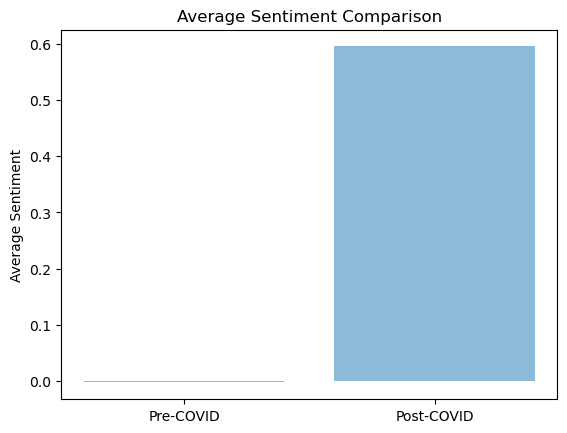

In [27]:
fig, ax = plt.subplots()
ax.bar(labels, scores, align='center', alpha=0.5)
ax.set_title('Average Sentiment Comparison')
ax.set_ylabel('Average Sentiment')
plt.show()

In these results, the average sentiment score (towards vaccines) for the Pre-COVID dataset is approximately 0.0, which suggests a balanced sentiment towards vaccines in general, with no clear leaning towards positive or negative emotions. On the other hand, the average sentiment score for the Post-COVID dataset is around 0.6, indicating that the overall sentiment (towards vaccines) of the dataset is more positive.